# Benchmarking Technical Indicators of Stocks with LSTM
## CS 5824
## Final Project

In [ ]:
# Run the two commands below (in google Colab), installation steps to get .pdf of the notebook.
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

# Table of Contents
* [Team Members](#Team)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Related Work](#Related-Work)
* [Background](#Background)
* [Method](#Method)
* [Results and Evaluation](#Results)
* [Sources](#Sources)


# <a name="Team"></a>Team Members

* [Jostein Barry-Straume](https://github.com/josteinstraume)

# <a name="Abstract"></a>Abstract

> In this case study, the application of Long-Term Short-Term Neural Network towards various Financial Technical Indicators is presented.

# <a name="Introduction"></a>Introduction

# <a name="Related-Work"></a>Related Work

# <a name="Background"></a>Background

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install talos

import talos as ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import random
import glob
import copy
from sklearn.preprocessing import MinMaxScaler
# Source:
# https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

random.seed(777)
np.random.seed(777)

%matplotlib inline

Mounted at /content/drive/
     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 5.4MB 7.0MB/s 
     |████████████████████████████████| 9.5MB 32.4MB/s 
     |████████████████████████████████| 2.6MB 44.0MB/s 
  Created wheel for chances: filename=chances-0.1.9-cp36-none-any.whl size=41610 sha256=1c8b5d9bd4fbe3330a65f7ef8a97712ae49dcb14326b39c1b1b46ec5b8e942c6
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315afb67eb14c6
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=0c804eceba042154d0a286b87e7eb25be261235b2443e6ba4b070c9763c93d3d
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp36-none-any.whl size=3603 sha256=8ca10465531d127209485eea427b195dbc1349fdcf1e64abb804e2add2ddba7e
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8

In [2]:
# Import test dataset
etfs = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'
all_etfs = glob.glob(etfs + "/*.txt")
sample_etfs = all_etfs[:10]
#all_stocks = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'

# Source:
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#df_etfs = pd.concat((pd.read_csv(f) for f in sample_etfs))
#df_stocks = pd.concat((pd.read_csv(f) for f in all_stocks))

df_etfs = []
prefix = '/content/drive/My Drive/CS5824/data/final-project/ETFs/'
for etf in sample_etfs:
  df = pd.read_csv(etf)
  # Get the name of the etf from the file path, split based on "." in file path
  # and then remove everything in the string except for the etf name
  # Source:
  # https://stackoverflow.com/questions/16891340/remove-a-prefix-from-a-string
  df['Name'] = etf.split(sep='.')[0].replace(prefix, "", 1)
  df['Date'] = pd.to_datetime(df['Date'])
  df_etfs.append(df)

df_etfs = pd.concat(df_etfs)

In [3]:
df_etfs.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl


In [4]:
'''
Exploratory data analysis.
Visually inspect the given dataframe by plotting the
time series line plots for each stock, or ETF, in said
dataframe
'''
def make_plot(df):
  sns.set_theme(style="darkgrid")
  sns.lineplot(data=df,
               x=df['Date'],
               y=df['Close'],
               palette="tab10",
               linewidth=2.5,
               hue=df['Name']
               )
  plt.show()

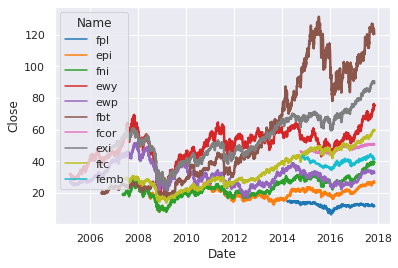

In [5]:
make_plot(df_etfs)

In [6]:
# Source:
# https://www.kaggle.com/kratisaxena/lstm-gru-models-for-stock-movement-analysis
def rsi(values):
  up = values[values>0].mean()
  down = -1*values[values<0].mean()
  return 100 * up / (up + down)

In [7]:
# Source:
# https://github.com/borisbanushev/stockpredictionai
def get_technical_indicators(dataset):
  # Create 7 and 21 days Moving Average
  dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
  dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

  # Create MACD
  dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
  dataset['12ema'] = dataset['Close'].ewm(span=26).mean()
  dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

  # Create Bollinger Bands
  dataset['20sd'] = dataset['Close'].rolling(20).std()
  dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
  dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

  # Create Exponential moving average
  dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

  # Create Momentum
  # Source: https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
  dataset['momentum'] = (dataset['Close'] - dataset['Close'].shift(1))
  dataset['log_momentum'] = np.log(dataset['Close'] / dataset['Close'].shift(1))

  # Create 14 day RSI
  dataset['rsi_14d'] = dataset['momentum'].rolling(center=False, window=14).apply(rsi)

  return dataset

In [8]:
# Create a new dataset with the above technical indicators
df_ti = get_technical_indicators(df_etfs)

In [9]:
df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,NaN,NaN,14.729000,14.729000,0.0,NaN,NaN,NaN,14.729000,NaN,NaN,NaN
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,NaN,NaN,14.729000,14.729000,0.0,NaN,NaN,NaN,14.729000,0.000,0.000000,NaN
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,NaN,NaN,14.781816,14.781816,0.0,NaN,NaN,NaN,14.830769,0.147,0.009931,NaN
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,NaN,NaN,14.767051,14.767051,0.0,NaN,NaN,NaN,14.762075,-0.147,-0.009931,NaN
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,NaN,NaN,14.762401,14.762401,0.0,NaN,NaN,NaN,14.751983,0.018,0.001221,NaN


In [10]:
df_ti = df_ti.fillna(df_ti.median())

In [11]:
df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [12]:
def plot_technical_indicators(dataset, last_days):
  plt.figure(figsize=(16, 10), dpi=100)
  shape_0 = dataset.shape[0]
  xmacd_ = shape_0-last_days

  dataset = dataset.iloc[-last_days:, :]
  x_ = range(3, dataset.shape[0])
  x_ =list(dataset.index)

  # Plot first subplot
  plt.subplot(2, 1, 1)
  plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
  plt.plot(dataset['Close'],label='Closing Price', color='b')
  plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
  plt.plot(dataset['upper_band'],label='Upper Band', color='c')
  plt.plot(dataset['lower_band'],label='Lower Band', color='c')
  plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
  plt.title('Technical indicators for {} - last {} days.'.format(dataset['Name'].values[0], last_days))
  plt.ylabel('USD')
  plt.legend()
  plt.show()

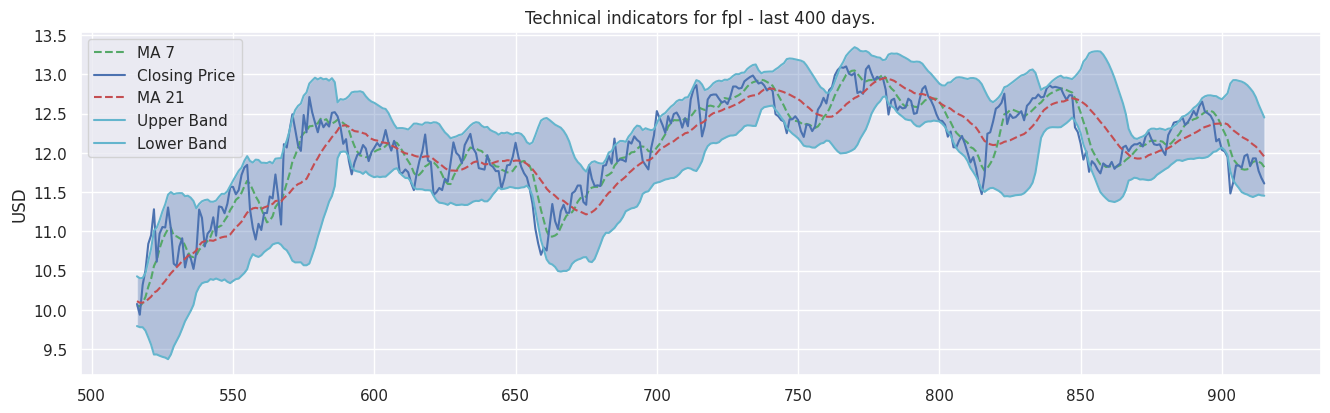

In [13]:
# Visually display the technical indicators
# for a given stock or ETF
plot_technical_indicators(df_ti[df_ti['Name'] == 'fpl'], 400)

# <a name="Method"></a>Method

In [14]:
def normalized_df(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [15]:
# Run analysis only on 1 ETF/stock


In [16]:
norm_df_ti = copy.deepcopy(df_ti[df_ti['Name'] == 'fpl'])

In [17]:
norm_df_ti.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Name,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
0,2014-03-27,14.705,14.795,14.698,14.729,698621,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
1,2014-03-28,14.890,14.890,14.729,14.729,164979,0,fpl,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2,2014-03-31,14.839,14.948,14.729,14.876,86108,0,fpl,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
3,2014-04-01,14.948,14.948,14.729,14.729,169637,0,fpl,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
4,2014-04-02,14.737,14.755,14.713,14.747,110332,0,fpl,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [18]:
ti_list = []

In [19]:
x = norm_df_ti['Name'][0]
ti_list.append(x)
norm_df_ti = norm_df_ti.drop('Name', 1)


In [20]:
norm_df_ti.index = norm_df_ti['Date']
norm_df_ti = norm_df_ti.drop('Date', 1)

In [21]:
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d
Date,,,,,,,,,,,,,,,,,,
2014-03-27,14.705,14.795,14.698,14.729,698621,0,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.024,0.000713,49.724699
2014-03-28,14.890,14.890,14.729,14.729,164979,0,32.818857,32.82819,14.729000,14.729000,0.0,0.67445,34.45069,31.105973,14.729000,0.000,0.000000,49.724699
2014-03-31,14.839,14.948,14.729,14.876,86108,0,32.818857,32.82819,14.781816,14.781816,0.0,0.67445,34.45069,31.105973,14.830769,0.147,0.009931,49.724699
2014-04-01,14.948,14.948,14.729,14.729,169637,0,32.818857,32.82819,14.767051,14.767051,0.0,0.67445,34.45069,31.105973,14.762075,-0.147,-0.009931,49.724699
2014-04-02,14.737,14.755,14.713,14.747,110332,0,32.818857,32.82819,14.762401,14.762401,0.0,0.67445,34.45069,31.105973,14.751983,0.018,0.001221,49.724699


In [22]:
mean = norm_df_ti.mean(axis = 0)
norm_df_ti -= mean
std = norm_df_ti.std(axis=0)
norm_df_ti /= std

In [23]:
# Add the label class based on whether stock goes up or down
def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

In [24]:
add_label(norm_df_ti)

In [25]:
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,NaN,8.848883,5.933812,1.512669,1.512669,NaN,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,NaN,8.848883,5.933812,1.512669,1.512669,NaN,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,NaN,8.848883,5.933812,1.545881,1.545881,NaN,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,NaN,8.848883,5.933812,1.536596,1.536596,NaN,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,NaN,8.848883,5.933812,1.533672,1.533672,NaN,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [26]:
norm_df_ti = norm_df_ti.fillna(0)

In [27]:
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,0.0,8.848883,5.933812,1.545881,1.545881,0.0,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,0.0,8.848883,5.933812,1.536596,1.536596,0.0,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,0.0,8.848883,5.933812,1.533672,1.533672,0.0,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [28]:
# Change dataframe into numpy array
#norm_df_ti = norm_df_ti.values

In [29]:
type(norm_df_ti)

pandas.core.frame.DataFrame

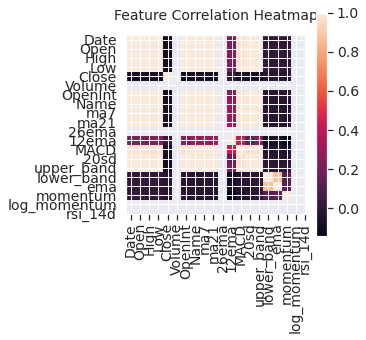

In [30]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df_ti)


# <a name="Results"></a>Results

In [31]:
norm_df_ti.head()

,Open,High,Low,Close,Volume,OpenInt,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,rsi_14d,Label
Date,,,,,,,,,,,,,,,,,,,
2014-03-27,1.466345,1.482241,1.528187,1.504163,5.896101,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.133906,0.049320,-0.130599,0
2014-03-28,1.579972,1.541975,1.546829,1.504163,0.207128,0.0,8.848883,5.933812,1.512669,1.512669,0.0,2.048385,6.141559,5.64584,1.506837,0.016525,0.013137,-0.130599,1
2014-03-31,1.548648,1.578444,1.546829,1.594660,-0.633689,0.0,8.848883,5.933812,1.545881,1.545881,0.0,2.048385,6.141559,5.64584,1.569643,0.735483,0.516851,-0.130599,1
2014-04-01,1.615595,1.578444,1.546829,1.504163,0.256785,0.0,8.848883,5.933812,1.536596,1.536596,0.0,2.048385,6.141559,5.64584,1.527249,-0.702433,-0.490578,-0.130599,0
2014-04-02,1.486000,1.457090,1.537207,1.515244,-0.375445,0.0,8.848883,5.933812,1.533672,1.533672,0.0,2.048385,6.141559,5.64584,1.521021,0.104561,0.075086,-0.130599,1


In [32]:
norm_df_ti.shape

(916, 19)

In [33]:
X_train = norm_df_ti[norm_df_ti.columns[:-1]][:800]
X_test = norm_df_ti[norm_df_ti.columns[:-1]][800:]
y_train = norm_df_ti[norm_df_ti.columns[-1]][:800]
y_test = norm_df_ti[norm_df_ti.columns[-1]][800:]

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(800, 18)
(116, 18)
(800,)
(116,)
(800, 18, 1)
(116, 18, 1)
(800, 1)
(116, 1)


In [34]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model3 = keras.Model(inputs=inputs, outputs=outputs)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test))
model3.evaluate(x=X_test, y=y_test)

Epoch 1/50
25/25 [==============================] - 1s 25ms/step - loss: 3.0922 - accuracy: 0.5188 - val_loss: 0.9492 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7398 - accuracy: 0.5375 - val_loss: 0.7016 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6293 - accuracy: 0.6500 - val_loss: 0.6494 - val_accuracy: 0.5517
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5916 - accuracy: 0.7900 - val_loss: 0.6187 - val_accuracy: 0.6207
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5489 - accuracy: 0.8000 - val_loss: 0.6018 - val_accuracy: 0.5862
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.5055 - accuracy: 0.8150 - val_loss: 0.5473 - val_accuracy: 0.8103
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4665 - accuracy: 0.8112 - val_loss: 0.5208 - val_accuracy: 0.7500
Epoch 8/50
25/25 [=

[0.057682063430547714, 0.982758641242981]

In [35]:
model3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [36]:
import talos as ta
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy

In [37]:
p = {'lr': (0.0001, 0.001, 0.005, 0.05, 0.01),
     'first_neuron': [8, 16, 32, 64],
     'epochs': [5, 10, 15, 20, 30, 40, 50],
     'optimizer': ['Adam', 'SGD', 'RMSprop'],
     'losses': ['binary_crossentropy']}

In [38]:
def build_lstm(X_train, y_train, X_test, y_test, params):
  inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
  lstm_out = keras.layers.LSTM(params['first_neuron'])(inputs)
  outputs = keras.layers.Dense(1)(lstm_out)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=params['optimizer'],
                loss=params['losses'],
                metrics=['accuracy'])
  history = model.fit(x=X_train, y=y_train, epochs=params['epochs'], validation_data=(X_test, y_test))
  return history, model

In [39]:
%time
scan_object = ta.Scan(x=X_train,
            y=y_train,
            model=build_lstm,
            params=p,
            seed=777,
            experiment_name='exp_run_1',
            x_val=X_test,
            y_val=y_test
           )

  0%|          | 0/84 [00:00<?, ?it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
Epoch 1/5
25/25 [==============================] - 1s 32ms/step - loss: 3.0757 - accuracy: 0.5188 - val_loss: 1.4124 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 1.2942 - accuracy: 0.5188 - val_loss: 1.2045 - val_accuracy: 0.4655
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 1.0398 - accuracy: 0.5188 - val_loss: 1.0935 - val_accuracy: 0.4655
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 0.9278 - accuracy: 0.5188 - val_loss: 0.9887 - val_accuracy: 0.4655
Epoch 5/5
25/25 [==============================] - 0s 8ms/step - loss: 0.8257 - accuracy: 0.5188 - val_loss: 0.8806 - val_accuracy: 0.4655


  1%|          | 1/84 [00:04<05:58,  4.32s/it]

Epoch 1/5
25/25 [==============================] - 1s 33ms/step - loss: 1.0443 - accuracy: 0.5512 - val_loss: 0.6361 - val_accuracy: 0.6983
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 0.6292 - accuracy: 0.6562 - val_loss: 0.5974 - val_accuracy: 0.7414
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6050 - accuracy: 0.6812 - val_loss: 0.5753 - val_accuracy: 0.7328
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5804 - accuracy: 0.6837 - val_loss: 0.5795 - val_accuracy: 0.7069
Epoch 5/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5635 - accuracy: 0.6925 - val_loss: 0.5763 - val_accuracy: 0.6810


  2%|▏         | 2/84 [00:08<05:53,  4.31s/it]

Epoch 1/5
25/25 [==============================] - 1s 24ms/step - loss: 2.7650 - accuracy: 0.5188 - val_loss: 1.3980 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 1.2534 - accuracy: 0.5188 - val_loss: 1.2177 - val_accuracy: 0.4655
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 1.0137 - accuracy: 0.5188 - val_loss: 1.0064 - val_accuracy: 0.4655
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.8129 - accuracy: 0.5188 - val_loss: 0.8124 - val_accuracy: 0.4655
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.6703 - accuracy: 0.5475 - val_loss: 0.6830 - val_accuracy: 0.4741


  4%|▎         | 3/84 [00:11<05:23,  3.99s/it]

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 5.3484 - accuracy: 0.4850 - val_loss: 1.9053 - val_accuracy: 0.4483
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 3.3915 - accuracy: 0.4625 - val_loss: 0.9283 - val_accuracy: 0.4397
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 1.1016 - accuracy: 0.4250 - val_loss: 0.7652 - val_accuracy: 0.2931
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.7769 - accuracy: 0.4200 - val_loss: 0.7261 - val_accuracy: 0.3707
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.7154 - accuracy: 0.4812 - val_loss: 0.6987 - val_accuracy: 0.4655


  5%|▍         | 4/84 [00:14<04:57,  3.71s/it]

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 1.4116 - accuracy: 0.3562 - val_loss: 0.7061 - val_accuracy: 0.3190
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 0.6601 - accuracy: 0.5962 - val_loss: 0.6441 - val_accuracy: 0.7069
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.6003 - accuracy: 0.6812 - val_loss: 0.6176 - val_accuracy: 0.6293
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5706 - accuracy: 0.6825 - val_loss: 0.5935 - val_accuracy: 0.6897
Epoch 5/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5530 - accuracy: 0.6900 - val_loss: 0.5965 - val_accuracy: 0.6034


  6%|▌         | 5/84 [00:17<04:35,  3.49s/it]

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 1.4315 - accuracy: 0.5300 - val_loss: 1.0723 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.7477 - accuracy: 0.5600 - val_loss: 0.8211 - val_accuracy: 0.4741
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6108 - accuracy: 0.6538 - val_loss: 0.6500 - val_accuracy: 0.4914
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5489 - accuracy: 0.7350 - val_loss: 0.6017 - val_accuracy: 0.5776
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5107 - accuracy: 0.7700 - val_loss: 0.5809 - val_accuracy: 0.5948


  7%|▋         | 6/84 [00:21<04:25,  3.41s/it]

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 1.6816 - accuracy: 0.5188 - val_loss: 1.0868 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 7ms/step - loss: 0.7372 - accuracy: 0.5362 - val_loss: 0.8076 - val_accuracy: 0.4741
Epoch 3/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6752 - accuracy: 0.6425 - val_loss: 0.6489 - val_accuracy: 0.4914
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 0.6232 - accuracy: 0.7437 - val_loss: 0.6166 - val_accuracy: 0.5517
Epoch 5/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5890 - accuracy: 0.7962 - val_loss: 0.5837 - val_accuracy: 0.6121


  8%|▊         | 7/84 [00:24<04:17,  3.35s/it]

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 0.7120 - accuracy: 0.6637 - val_loss: 0.6113 - val_accuracy: 0.6552
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5654 - accuracy: 0.6938 - val_loss: 0.5897 - val_accuracy: 0.6552
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5448 - accuracy: 0.7138 - val_loss: 0.5943 - val_accuracy: 0.6121
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5506 - accuracy: 0.7000 - val_loss: 0.5997 - val_accuracy: 0.5948
Epoch 5/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5390 - accuracy: 0.7175 - val_loss: 0.5944 - val_accuracy: 0.6034


 10%|▉         | 8/84 [00:27<04:08,  3.27s/it]

Epoch 1/5
25/25 [==============================] - 1s 24ms/step - loss: 1.1010 - accuracy: 0.5213 - val_loss: 0.9176 - val_accuracy: 0.4655
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6512 - accuracy: 0.6375 - val_loss: 0.6207 - val_accuracy: 0.5603
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 0.6002 - accuracy: 0.7337 - val_loss: 0.5747 - val_accuracy: 0.6379
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 0.5337 - accuracy: 0.7750 - val_loss: 0.4985 - val_accuracy: 0.7759
Epoch 5/5
25/25 [==============================] - 0s 6ms/step - loss: 0.4767 - accuracy: 0.8000 - val_loss: 0.4539 - val_accuracy: 0.7931


 11%|█         | 9/84 [00:30<04:06,  3.29s/it]

Epoch 1/5
25/25 [==============================] - 1s 29ms/step - loss: 1.4806 - accuracy: 0.5450 - val_loss: 0.7415 - val_accuracy: 0.4741
Epoch 2/5
25/25 [==============================] - 0s 11ms/step - loss: 0.6312 - accuracy: 0.7387 - val_loss: 0.6027 - val_accuracy: 0.5690
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 0.5511 - accuracy: 0.7763 - val_loss: 0.5388 - val_accuracy: 0.6897
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 0.5011 - accuracy: 0.7825 - val_loss: 0.4843 - val_accuracy: 0.7845
Epoch 5/5
25/25 [==============================] - 0s 10ms/step - loss: 0.4677 - accuracy: 0.8112 - val_loss: 0.4545 - val_accuracy: 0.7759


 12%|█▏        | 10/84 [00:34<04:16,  3.46s/it]

Epoch 1/5
25/25 [==============================] - 1s 28ms/step - loss: 2.4651 - accuracy: 0.6125 - val_loss: 0.9927 - val_accuracy: 0.6552
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 0.5836 - accuracy: 0.6938 - val_loss: 0.7685 - val_accuracy: 0.6466
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 0.5703 - accuracy: 0.7013 - val_loss: 0.5903 - val_accuracy: 0.6983
Epoch 4/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5625 - accuracy: 0.7075 - val_loss: 0.6188 - val_accuracy: 0.6724
Epoch 5/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5418 - accuracy: 0.7100 - val_loss: 0.6987 - val_accuracy: 0.5948


 13%|█▎        | 11/84 [00:38<04:20,  3.57s/it]

Epoch 1/5
25/25 [==============================] - 1s 27ms/step - loss: 1.1328 - accuracy: 0.5525 - val_loss: 0.6503 - val_accuracy: 0.4914
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 0.5921 - accuracy: 0.7487 - val_loss: 0.5503 - val_accuracy: 0.6638
Epoch 3/5
25/25 [==============================] - 0s 9ms/step - loss: 0.5205 - accuracy: 0.7962 - val_loss: 0.4592 - val_accuracy: 0.8103
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 0.4336 - accuracy: 0.8325 - val_loss: 0.3585 - val_accuracy: 0.9138
Epoch 5/5
25/25 [==============================] - 0s 11ms/step - loss: 0.3536 - accuracy: 0.8888 - val_loss: 0.2509 - val_accuracy: 0.9310


 14%|█▍        | 12/84 [00:42<04:27,  3.72s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 2.4510 - accuracy: 0.5213 - val_loss: 3.5852 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.8024 - accuracy: 0.5263 - val_loss: 2.5210 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.5059 - accuracy: 0.5412 - val_loss: 2.0611 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 1.3444 - accuracy: 0.5800 - val_loss: 1.6409 - val_accuracy: 0.4741
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 1.0800 - accuracy: 0.6062 - val_loss: 1.2177 - val_accuracy: 0.4741
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7454 - accuracy: 0.6338 - val_loss: 0.7482 - val_accuracy: 0.4828
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6194 - accuracy: 0.6662 - val_loss: 0.6730 - val_accuracy: 0.5000
Epoch 8/10
25/25 [=

 15%|█▌        | 13/84 [00:46<04:28,  3.78s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 1.1034 - accuracy: 0.5150 - val_loss: 0.6902 - val_accuracy: 0.4569
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.5888 - val_loss: 0.6492 - val_accuracy: 0.6724
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6205 - accuracy: 0.6687 - val_loss: 0.6255 - val_accuracy: 0.6638
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5927 - accuracy: 0.6700 - val_loss: 0.6123 - val_accuracy: 0.6552
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5770 - accuracy: 0.6825 - val_loss: 0.6024 - val_accuracy: 0.6552
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5804 - accuracy: 0.6862 - val_loss: 0.6009 - val_accuracy: 0.6293
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5724 - accuracy: 0.6900 - val_loss: 0.5861 - val_accuracy: 0.6724
Epoch 8/10
25/25 [=

 17%|█▋        | 14/84 [00:50<04:24,  3.77s/it]

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 1.1864 - accuracy: 0.5188 - val_loss: 1.2911 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 0.8336 - accuracy: 0.5250 - val_loss: 0.9848 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.6561 - accuracy: 0.5825 - val_loss: 0.7685 - val_accuracy: 0.4741
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5601 - accuracy: 0.6875 - val_loss: 0.6401 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.5147 - accuracy: 0.7538 - val_loss: 0.5841 - val_accuracy: 0.5690
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.4849 - accuracy: 0.7763 - val_loss: 0.5614 - val_accuracy: 0.6121
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.4634 - accuracy: 0.7688 - val_loss: 0.5266 - val_accuracy: 0.6724
Epoch 8/10
25/25 [=

 18%|█▊        | 15/84 [00:54<04:23,  3.82s/it]

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 4.3939 - accuracy: 0.5188 - val_loss: 1.6945 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 1.7731 - accuracy: 0.5188 - val_loss: 1.0919 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 0.9650 - accuracy: 0.5188 - val_loss: 0.9689 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8583 - accuracy: 0.5188 - val_loss: 0.9109 - val_accuracy: 0.4655
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8006 - accuracy: 0.5188 - val_loss: 0.8646 - val_accuracy: 0.4655
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7544 - accuracy: 0.5312 - val_loss: 0.8216 - val_accuracy: 0.4655
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7151 - accuracy: 0.5350 - val_loss: 0.7837 - val_accuracy: 0.4655
Epoch 8/10
25/25 [=

 19%|█▉        | 16/84 [00:57<04:20,  3.84s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 0.7304 - accuracy: 0.6687 - val_loss: 0.6155 - val_accuracy: 0.7155
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5771 - accuracy: 0.6950 - val_loss: 0.6021 - val_accuracy: 0.6810
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5573 - accuracy: 0.7075 - val_loss: 0.5967 - val_accuracy: 0.6810
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5573 - accuracy: 0.7113 - val_loss: 0.5982 - val_accuracy: 0.6552
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5481 - accuracy: 0.7125 - val_loss: 0.5955 - val_accuracy: 0.6552
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5413 - accuracy: 0.7163 - val_loss: 0.5759 - val_accuracy: 0.6897
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5364 - accuracy: 0.7188 - val_loss: 0.5836 - val_accuracy: 0.6810
Epoch 8/10
25/25 [=

 20%|██        | 17/84 [01:01<04:18,  3.86s/it]

Epoch 1/10
25/25 [==============================] - 1s 27ms/step - loss: 1.9126 - accuracy: 0.5188 - val_loss: 1.8050 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8851 - accuracy: 0.5200 - val_loss: 1.0613 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.7138 - accuracy: 0.5713 - val_loss: 0.7833 - val_accuracy: 0.4741
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5874 - accuracy: 0.6600 - val_loss: 0.6194 - val_accuracy: 0.5690
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5710 - accuracy: 0.7300 - val_loss: 0.5855 - val_accuracy: 0.6379
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5541 - accuracy: 0.7550 - val_loss: 0.5480 - val_accuracy: 0.7241
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5288 - accuracy: 0.7738 - val_loss: 0.5058 - val_accuracy: 0.8017
Epoch 8/10
25/25 [=

 21%|██▏       | 18/84 [01:06<04:32,  4.13s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 1.6013 - accuracy: 0.5188 - val_loss: 1.3135 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9490 - accuracy: 0.5175 - val_loss: 1.0645 - val_accuracy: 0.4655
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.7526 - accuracy: 0.5362 - val_loss: 0.8195 - val_accuracy: 0.4655
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.6150 - val_loss: 0.6545 - val_accuracy: 0.4914
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.7175 - val_loss: 0.6384 - val_accuracy: 0.5172
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6278 - accuracy: 0.7625 - val_loss: 0.6059 - val_accuracy: 0.6034
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6015 - accuracy: 0.7575 - val_loss: 0.5899 - val_accuracy: 0.6034
Epoch 8/10
25/25 [=

 23%|██▎       | 19/84 [01:10<04:31,  4.18s/it]

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 0.7658 - accuracy: 0.6087 - val_loss: 0.6445 - val_accuracy: 0.5259
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5954 - accuracy: 0.6687 - val_loss: 0.6118 - val_accuracy: 0.6466
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5717 - accuracy: 0.6862 - val_loss: 0.6217 - val_accuracy: 0.5690
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5536 - accuracy: 0.7025 - val_loss: 0.6115 - val_accuracy: 0.5948
Epoch 5/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5559 - accuracy: 0.7038 - val_loss: 0.6031 - val_accuracy: 0.6293
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5449 - accuracy: 0.7113 - val_loss: 0.5847 - val_accuracy: 0.6810
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5354 - accuracy: 0.7113 - val_loss: 0.5867 - val_accuracy: 0.6638
Epoch 8/10
25/25 [=

 24%|██▍       | 20/84 [01:14<04:22,  4.10s/it]

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 1.5513 - accuracy: 0.5188 - val_loss: 0.9223 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.6168 - accuracy: 0.6475 - val_loss: 0.6020 - val_accuracy: 0.5948
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5422 - accuracy: 0.7600 - val_loss: 0.5785 - val_accuracy: 0.6034
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5189 - accuracy: 0.7887 - val_loss: 0.4680 - val_accuracy: 0.8190
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4837 - accuracy: 0.8138 - val_loss: 0.4519 - val_accuracy: 0.7931
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4362 - accuracy: 0.8425 - val_loss: 0.3516 - val_accuracy: 0.9052
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3676 - accuracy: 0.8875 - val_loss: 0.3204 - val_accuracy: 0.8707
Epoch 8/10
25/25 [=

 25%|██▌       | 21/84 [01:18<04:17,  4.09s/it]

Epoch 1/10
25/25 [==============================] - 1s 26ms/step - loss: 2.2944 - accuracy: 0.5337 - val_loss: 0.7361 - val_accuracy: 0.4655
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 0.6598 - accuracy: 0.7588 - val_loss: 0.5934 - val_accuracy: 0.7241
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5749 - accuracy: 0.8338 - val_loss: 0.5507 - val_accuracy: 0.6897
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5051 - accuracy: 0.8700 - val_loss: 0.4670 - val_accuracy: 0.8707
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4484 - accuracy: 0.8587 - val_loss: 0.4200 - val_accuracy: 0.8448
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4057 - accuracy: 0.8637 - val_loss: 0.3939 - val_accuracy: 0.8190
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.3650 - accuracy: 0.8913 - val_loss: 0.3076 - val_accuracy: 0.9224
Epoch 8/10
25/25 [

 26%|██▌       | 22/84 [01:23<04:25,  4.28s/it]

Epoch 1/10
25/25 [==============================] - 1s 25ms/step - loss: 0.9278 - accuracy: 0.6400 - val_loss: 0.6209 - val_accuracy: 0.5690
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5692 - accuracy: 0.6862 - val_loss: 0.6012 - val_accuracy: 0.6034
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5487 - accuracy: 0.7000 - val_loss: 0.5821 - val_accuracy: 0.7241
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5406 - accuracy: 0.7113 - val_loss: 0.5866 - val_accuracy: 0.6810
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5313 - accuracy: 0.7138 - val_loss: 0.5893 - val_accuracy: 0.6552
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5373 - accuracy: 0.7125 - val_loss: 0.5921 - val_accuracy: 0.6552
Epoch 7/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5308 - accuracy: 0.7200 - val_loss: 0.5868 - val_accuracy: 0.6552
Epoch 8/10
25/25 [=

 27%|██▋       | 23/84 [01:28<04:25,  4.35s/it]

Epoch 1/10
25/25 [==============================] - 1s 26ms/step - loss: 0.9598 - accuracy: 0.5500 - val_loss: 0.7293 - val_accuracy: 0.4741
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - loss: 0.6040 - accuracy: 0.7262 - val_loss: 0.6016 - val_accuracy: 0.5690
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5469 - accuracy: 0.7437 - val_loss: 0.4875 - val_accuracy: 0.7845
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.5125 - accuracy: 0.7862 - val_loss: 0.5116 - val_accuracy: 0.7155
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4607 - accuracy: 0.8000 - val_loss: 0.4219 - val_accuracy: 0.8190
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.4148 - accuracy: 0.8338 - val_loss: 0.3968 - val_accuracy: 0.7759
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.3909 - accuracy: 0.8587 - val_loss: 0.2867 - val_accuracy: 0.9310
Epoch 8/10
25/25 [=

 29%|██▊       | 24/84 [01:32<04:27,  4.47s/it]

Epoch 1/15
25/25 [==============================] - 1s 21ms/step - loss: 1.7079 - accuracy: 0.5188 - val_loss: 1.3105 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.8942 - accuracy: 0.5188 - val_loss: 0.9535 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.5250 - val_loss: 0.7728 - val_accuracy: 0.4655
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 0.6120 - accuracy: 0.5913 - val_loss: 0.6516 - val_accuracy: 0.4828
Epoch 5/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5682 - accuracy: 0.7100 - val_loss: 0.6077 - val_accuracy: 0.5603
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5441 - accuracy: 0.7312 - val_loss: 0.5921 - val_accuracy: 0.5862
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5236 - accuracy: 0.7362 - val_loss: 0.5803 - val_accuracy: 0.5948
Epoch 8/15
25/25 [=

 30%|██▉       | 25/84 [01:37<04:23,  4.46s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 0.9589 - accuracy: 0.6000 - val_loss: 0.6286 - val_accuracy: 0.7931
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.6184 - accuracy: 0.6750 - val_loss: 0.5987 - val_accuracy: 0.7845
Epoch 3/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5768 - accuracy: 0.7075 - val_loss: 0.5814 - val_accuracy: 0.7500
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5515 - accuracy: 0.7188 - val_loss: 0.5699 - val_accuracy: 0.7069
Epoch 5/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5324 - accuracy: 0.7237 - val_loss: 0.5596 - val_accuracy: 0.7069
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5175 - accuracy: 0.7362 - val_loss: 0.5514 - val_accuracy: 0.7155
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5041 - accuracy: 0.7437 - val_loss: 0.5462 - val_accuracy: 0.7069
Epoch 8/15
25/25 [=

 31%|███       | 26/84 [01:41<04:16,  4.42s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 4.9105 - accuracy: 0.5188 - val_loss: 2.6461 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 2.4986 - accuracy: 0.5188 - val_loss: 1.4611 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 1.2485 - accuracy: 0.5188 - val_loss: 1.2332 - val_accuracy: 0.4655
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 0.9994 - accuracy: 0.5188 - val_loss: 0.9952 - val_accuracy: 0.4655
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.7887 - accuracy: 0.5213 - val_loss: 0.7910 - val_accuracy: 0.4655
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 0.6567 - accuracy: 0.5663 - val_loss: 0.6738 - val_accuracy: 0.4741
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.6016 - accuracy: 0.6363 - val_loss: 0.6347 - val_accuracy: 0.5172
Epoch 8/15
25/25 [=

 32%|███▏      | 27/84 [01:46<04:17,  4.52s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 2.1379 - accuracy: 0.5188 - val_loss: 1.1458 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.8197 - accuracy: 0.5238 - val_loss: 0.8884 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6709 - accuracy: 0.5650 - val_loss: 0.7253 - val_accuracy: 0.4741
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6262 - accuracy: 0.6438 - val_loss: 0.6669 - val_accuracy: 0.4914
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6044 - accuracy: 0.6775 - val_loss: 0.6488 - val_accuracy: 0.5172
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5862 - accuracy: 0.7075 - val_loss: 0.6266 - val_accuracy: 0.5690
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5551 - accuracy: 0.7287 - val_loss: 0.6147 - val_accuracy: 0.5948
Epoch 8/15
25/25 [=

 33%|███▎      | 28/84 [01:51<04:15,  4.56s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 1.0613 - accuracy: 0.5675 - val_loss: 0.6346 - val_accuracy: 0.6293
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5967 - accuracy: 0.6600 - val_loss: 0.6248 - val_accuracy: 0.5776
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5694 - accuracy: 0.6762 - val_loss: 0.6095 - val_accuracy: 0.5776
Epoch 4/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5565 - accuracy: 0.6888 - val_loss: 0.5780 - val_accuracy: 0.6897
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5473 - accuracy: 0.6913 - val_loss: 0.5938 - val_accuracy: 0.6207
Epoch 6/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5417 - accuracy: 0.7050 - val_loss: 0.5649 - val_accuracy: 0.7328
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5332 - accuracy: 0.7200 - val_loss: 0.5561 - val_accuracy: 0.7759
Epoch 8/15
25/25 [=

 35%|███▍      | 29/84 [01:55<04:10,  4.56s/it]

Epoch 1/15
25/25 [==============================] - 1s 23ms/step - loss: 1.1978 - accuracy: 0.5188 - val_loss: 1.0433 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.5663 - val_loss: 0.7671 - val_accuracy: 0.4741
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6205 - accuracy: 0.6075 - val_loss: 0.6827 - val_accuracy: 0.4828
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5938 - accuracy: 0.6637 - val_loss: 0.6321 - val_accuracy: 0.5431
Epoch 5/15
25/25 [==============================] - 0s 5ms/step - loss: 0.5723 - accuracy: 0.6938 - val_loss: 0.6156 - val_accuracy: 0.5776
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5436 - accuracy: 0.7175 - val_loss: 0.6002 - val_accuracy: 0.5948
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5152 - accuracy: 0.7350 - val_loss: 0.5585 - val_accuracy: 0.6897
Epoch 8/15
25/25 [=

 36%|███▌      | 30/84 [02:00<04:08,  4.60s/it]

Epoch 1/15
25/25 [==============================] - 1s 24ms/step - loss: 1.2899 - accuracy: 0.5225 - val_loss: 1.1492 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.7888 - accuracy: 0.5500 - val_loss: 0.8433 - val_accuracy: 0.4741
Epoch 3/15
25/25 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.6200 - val_loss: 0.6784 - val_accuracy: 0.4741
Epoch 4/15
25/25 [==============================] - 0s 7ms/step - loss: 0.6336 - accuracy: 0.7063 - val_loss: 0.6334 - val_accuracy: 0.5259
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5947 - accuracy: 0.7775 - val_loss: 0.5857 - val_accuracy: 0.6034
Epoch 6/15
25/25 [==============================] - 0s 7ms/step - loss: 0.5574 - accuracy: 0.8112 - val_loss: 0.5468 - val_accuracy: 0.7069
Epoch 7/15
25/25 [==============================] - 0s 7ms/step - loss: 0.5214 - accuracy: 0.8188 - val_loss: 0.5270 - val_accuracy: 0.7069
Epoch 8/15
25/25 [=

 37%|███▋      | 31/84 [02:05<04:10,  4.72s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 0.9729 - accuracy: 0.5587 - val_loss: 0.6532 - val_accuracy: 0.5517
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5951 - accuracy: 0.7113 - val_loss: 0.6177 - val_accuracy: 0.6379
Epoch 3/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5594 - accuracy: 0.7050 - val_loss: 0.6078 - val_accuracy: 0.6207
Epoch 4/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5469 - accuracy: 0.7113 - val_loss: 0.6011 - val_accuracy: 0.6293
Epoch 5/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5500 - accuracy: 0.7138 - val_loss: 0.5888 - val_accuracy: 0.6638
Epoch 6/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5430 - accuracy: 0.7100 - val_loss: 0.5850 - val_accuracy: 0.6638
Epoch 7/15
25/25 [==============================] - 0s 6ms/step - loss: 0.5371 - accuracy: 0.7125 - val_loss: 0.6045 - val_accuracy: 0.6293
Epoch 8/15
25/25 [=

 38%|███▊      | 32/84 [02:10<04:06,  4.73s/it]

Epoch 1/15
25/25 [==============================] - 1s 22ms/step - loss: 1.0972 - accuracy: 0.5550 - val_loss: 0.7927 - val_accuracy: 0.4741
Epoch 2/15
25/25 [==============================] - 0s 6ms/step - loss: 0.6269 - accuracy: 0.7013 - val_loss: 0.6059 - val_accuracy: 0.5690
Epoch 3/15
25/25 [==============================] - 0s 7ms/step - loss: 0.5516 - accuracy: 0.7475 - val_loss: 0.5319 - val_accuracy: 0.7328
Epoch 4/15
25/25 [==============================] - 0s 7ms/step - loss: 0.4978 - accuracy: 0.7950 - val_loss: 0.4579 - val_accuracy: 0.8103
Epoch 5/15
25/25 [==============================] - 0s 7ms/step - loss: 0.4964 - accuracy: 0.8112 - val_loss: 0.4009 - val_accuracy: 0.8276
Epoch 6/15
25/25 [==============================] - 0s 7ms/step - loss: 0.4377 - accuracy: 0.8213 - val_loss: 0.3734 - val_accuracy: 0.8879
Epoch 7/15
25/25 [==============================] - 0s 7ms/step - loss: 0.3965 - accuracy: 0.8562 - val_loss: 0.3322 - val_accuracy: 0.9138
Epoch 8/15
25/25 [=

 39%|███▉      | 33/84 [02:15<04:05,  4.82s/it]

Epoch 1/15
25/25 [==============================] - 1s 25ms/step - loss: 1.6323 - accuracy: 0.5325 - val_loss: 1.0710 - val_accuracy: 0.4655
Epoch 2/15
25/25 [==============================] - 0s 8ms/step - loss: 0.8010 - accuracy: 0.5325 - val_loss: 0.9273 - val_accuracy: 0.4655
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 0.7262 - accuracy: 0.5550 - val_loss: 0.8290 - val_accuracy: 0.4741
Epoch 4/15
25/25 [==============================] - 0s 9ms/step - loss: 0.6822 - accuracy: 0.5987 - val_loss: 0.7264 - val_accuracy: 0.4741
Epoch 5/15
25/25 [==============================] - 0s 8ms/step - loss: 0.6318 - accuracy: 0.7075 - val_loss: 0.6299 - val_accuracy: 0.5259
Epoch 6/15
25/25 [==============================] - 0s 8ms/step - loss: 0.5966 - accuracy: 0.7688 - val_loss: 0.5937 - val_accuracy: 0.5948
Epoch 7/15
25/25 [==============================] - 0s 9ms/step - loss: 0.5710 - accuracy: 0.7713 - val_loss: 0.5934 - val_accuracy: 0.5776
Epoch 8/15
25/25 [=

 40%|████      | 34/84 [02:20<04:14,  5.09s/it]

Epoch 1/15
25/25 [==============================] - 1s 25ms/step - loss: 7.7591 - accuracy: 0.4837 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/15
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/15
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/15
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/15
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/15
25/25 [=

 42%|████▏     | 35/84 [02:26<04:17,  5.25s/it]

Epoch 1/15
25/25 [==============================] - 1s 25ms/step - loss: 1.5581 - accuracy: 0.6025 - val_loss: 0.6218 - val_accuracy: 0.5345
Epoch 2/15
25/25 [==============================] - 0s 9ms/step - loss: 0.5791 - accuracy: 0.7738 - val_loss: 0.6036 - val_accuracy: 0.5517
Epoch 3/15
25/25 [==============================] - 0s 9ms/step - loss: 0.4940 - accuracy: 0.8225 - val_loss: 0.4367 - val_accuracy: 0.8448
Epoch 4/15
25/25 [==============================] - 0s 9ms/step - loss: 0.4584 - accuracy: 0.8275 - val_loss: 0.3866 - val_accuracy: 0.8448
Epoch 5/15
25/25 [==============================] - 0s 9ms/step - loss: 0.3974 - accuracy: 0.8775 - val_loss: 0.3102 - val_accuracy: 0.9224
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 0.3499 - accuracy: 0.8900 - val_loss: 0.2831 - val_accuracy: 0.8966
Epoch 7/15
25/25 [==============================] - 0s 8ms/step - loss: 0.3529 - accuracy: 0.9162 - val_loss: 0.2201 - val_accuracy: 0.9569
Epoch 8/15
25/25 [=

 43%|████▎     | 36/84 [02:32<04:21,  5.46s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 4.8860 - accuracy: 0.5188 - val_loss: 3.1711 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 3.1992 - accuracy: 0.5188 - val_loss: 1.5717 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 1.7126 - accuracy: 0.5188 - val_loss: 1.3729 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 1.2116 - accuracy: 0.5188 - val_loss: 1.2766 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 1.0901 - accuracy: 0.5188 - val_loss: 1.2081 - val_accuracy: 0.4655
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 1.0213 - accuracy: 0.5188 - val_loss: 1.1535 - val_accuracy: 0.4655
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.9662 - accuracy: 0.5188 - val_loss: 1.1010 - val_accuracy: 0.4655
Epoch 8/20
25/25 [=

 44%|████▍     | 37/84 [02:37<04:14,  5.41s/it]

Epoch 1/20
25/25 [==============================] - 1s 22ms/step - loss: 1.0889 - accuracy: 0.4988 - val_loss: 0.6708 - val_accuracy: 0.6724
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6606 - accuracy: 0.6212 - val_loss: 0.6422 - val_accuracy: 0.6897
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6194 - accuracy: 0.6812 - val_loss: 0.6278 - val_accuracy: 0.6638
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5911 - accuracy: 0.6875 - val_loss: 0.6086 - val_accuracy: 0.6724
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5720 - accuracy: 0.6775 - val_loss: 0.5983 - val_accuracy: 0.6724
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5580 - accuracy: 0.6875 - val_loss: 0.5918 - val_accuracy: 0.6552
Epoch 7/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 0.6963 - val_loss: 0.5845 - val_accuracy: 0.6724
Epoch 8/20
25/25 [=

 45%|████▌     | 38/84 [02:42<04:05,  5.35s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 1.3169 - accuracy: 0.5213 - val_loss: 1.2950 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7015 - accuracy: 0.6012 - val_loss: 0.7740 - val_accuracy: 0.4828
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5553 - accuracy: 0.6938 - val_loss: 0.6117 - val_accuracy: 0.5603
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5148 - accuracy: 0.7225 - val_loss: 0.5567 - val_accuracy: 0.6552
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4948 - accuracy: 0.7412 - val_loss: 0.5566 - val_accuracy: 0.6638
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4795 - accuracy: 0.7513 - val_loss: 0.5121 - val_accuracy: 0.7586
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4662 - accuracy: 0.7487 - val_loss: 0.5072 - val_accuracy: 0.7672
Epoch 8/20
25/25 [=

 46%|████▋     | 39/84 [02:48<04:02,  5.39s/it]

Epoch 1/20
25/25 [==============================] - 1s 22ms/step - loss: 1.8182 - accuracy: 0.5188 - val_loss: 2.0244 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 1.2627 - accuracy: 0.5188 - val_loss: 1.8207 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 1.1929 - accuracy: 0.5188 - val_loss: 1.6651 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 1.1535 - accuracy: 0.5188 - val_loss: 1.5273 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 1.1148 - accuracy: 0.5188 - val_loss: 1.4705 - val_accuracy: 0.4655
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 1.0767 - accuracy: 0.5188 - val_loss: 1.4225 - val_accuracy: 0.4655
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 1.0392 - accuracy: 0.5188 - val_loss: 1.3750 - val_accuracy: 0.4655
Epoch 8/20
25/25 [=

 48%|████▊     | 40/84 [02:53<03:57,  5.39s/it]

Epoch 1/20
25/25 [==============================] - 1s 22ms/step - loss: 0.8709 - accuracy: 0.5975 - val_loss: 0.6669 - val_accuracy: 0.4914
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6110 - accuracy: 0.6513 - val_loss: 0.6391 - val_accuracy: 0.5172
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5870 - accuracy: 0.6750 - val_loss: 0.6340 - val_accuracy: 0.5172
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5735 - accuracy: 0.6712 - val_loss: 0.6217 - val_accuracy: 0.5431
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5767 - accuracy: 0.6812 - val_loss: 0.6182 - val_accuracy: 0.5603
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5688 - accuracy: 0.6862 - val_loss: 0.6128 - val_accuracy: 0.5690
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5587 - accuracy: 0.6837 - val_loss: 0.6095 - val_accuracy: 0.5690
Epoch 8/20
25/25 [=

 49%|████▉     | 41/84 [02:59<03:51,  5.37s/it]

Epoch 1/20
25/25 [==============================] - 1s 24ms/step - loss: 2.5493 - accuracy: 0.5175 - val_loss: 1.1665 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 1.1412 - accuracy: 0.5188 - val_loss: 1.0911 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.9711 - accuracy: 0.5200 - val_loss: 0.9480 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7987 - accuracy: 0.5325 - val_loss: 0.7962 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5638 - val_loss: 0.6640 - val_accuracy: 0.6552
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7022 - accuracy: 0.6550 - val_loss: 0.6418 - val_accuracy: 0.5345
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6362 - accuracy: 0.7525 - val_loss: 0.5835 - val_accuracy: 0.6897
Epoch 8/20
25/25 [=

 50%|█████     | 42/84 [03:04<03:49,  5.46s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 1.6657 - accuracy: 0.5188 - val_loss: 1.6559 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 1.3651 - accuracy: 0.5188 - val_loss: 1.6165 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 1.3012 - accuracy: 0.5188 - val_loss: 1.6044 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 7ms/step - loss: 1.2567 - accuracy: 0.5188 - val_loss: 1.5941 - val_accuracy: 0.4655
Epoch 5/20
25/25 [==============================] - 0s 7ms/step - loss: 1.2182 - accuracy: 0.5188 - val_loss: 1.5778 - val_accuracy: 0.4655
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 1.1842 - accuracy: 0.5188 - val_loss: 1.5600 - val_accuracy: 0.4655
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 1.1522 - accuracy: 0.5188 - val_loss: 1.5377 - val_accuracy: 0.4655
Epoch 8/20
25/25 [=

 51%|█████     | 43/84 [03:10<03:47,  5.56s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 0.7778 - accuracy: 0.6338 - val_loss: 0.6326 - val_accuracy: 0.5517
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5556 - accuracy: 0.6925 - val_loss: 0.6221 - val_accuracy: 0.5776
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5469 - accuracy: 0.6938 - val_loss: 0.6032 - val_accuracy: 0.6379
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5417 - accuracy: 0.7100 - val_loss: 0.5830 - val_accuracy: 0.6897
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5357 - accuracy: 0.7163 - val_loss: 0.5943 - val_accuracy: 0.6552
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5448 - accuracy: 0.7100 - val_loss: 0.5931 - val_accuracy: 0.6466
Epoch 7/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5386 - accuracy: 0.7138 - val_loss: 0.5964 - val_accuracy: 0.6379
Epoch 8/20
25/25 [=

 52%|█████▏    | 44/84 [03:16<03:41,  5.55s/it]

Epoch 1/20
25/25 [==============================] - 1s 23ms/step - loss: 1.0087 - accuracy: 0.5487 - val_loss: 0.7728 - val_accuracy: 0.4741
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5625 - accuracy: 0.6963 - val_loss: 0.5494 - val_accuracy: 0.7759
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5404 - accuracy: 0.7650 - val_loss: 0.5613 - val_accuracy: 0.6466
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5258 - accuracy: 0.7850 - val_loss: 0.5248 - val_accuracy: 0.7069
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4808 - accuracy: 0.8112 - val_loss: 0.4060 - val_accuracy: 0.8276
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 0.4445 - accuracy: 0.8288 - val_loss: 0.3978 - val_accuracy: 0.8534
Epoch 7/20
25/25 [==============================] - 0s 7ms/step - loss: 0.3917 - accuracy: 0.8587 - val_loss: 0.3127 - val_accuracy: 0.9224
Epoch 8/20
25/25 [=

 54%|█████▎    | 45/84 [03:21<03:39,  5.64s/it]

Epoch 1/20
25/25 [==============================] - 1s 25ms/step - loss: 1.5319 - accuracy: 0.5250 - val_loss: 1.1993 - val_accuracy: 0.4655
Epoch 2/20
25/25 [==============================] - 0s 8ms/step - loss: 0.8475 - accuracy: 0.5375 - val_loss: 1.0365 - val_accuracy: 0.4655
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 0.7936 - accuracy: 0.5475 - val_loss: 0.9135 - val_accuracy: 0.4655
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.7345 - accuracy: 0.5850 - val_loss: 0.7798 - val_accuracy: 0.4741
Epoch 5/20
25/25 [==============================] - 0s 8ms/step - loss: 0.6854 - accuracy: 0.6275 - val_loss: 0.6640 - val_accuracy: 0.4914
Epoch 6/20
25/25 [==============================] - 0s 8ms/step - loss: 0.6482 - accuracy: 0.7050 - val_loss: 0.6243 - val_accuracy: 0.5690
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.6265 - accuracy: 0.7638 - val_loss: 0.6029 - val_accuracy: 0.6207
Epoch 8/20
25/25 [=

 55%|█████▍    | 46/84 [03:28<03:47,  6.00s/it]

Epoch 1/20
25/25 [==============================] - 1s 24ms/step - loss: 7.9095 - accuracy: 0.4737 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 7.9106 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 7.9106 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/20
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/20
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/20
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/20
25/25 [==============================] - 0s 8ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/20
25/25 [=

 56%|█████▌    | 47/84 [03:35<03:49,  6.21s/it]

Epoch 1/20
25/25 [==============================] - 1s 25ms/step - loss: 0.9116 - accuracy: 0.6300 - val_loss: 0.6305 - val_accuracy: 0.5259
Epoch 2/20
25/25 [==============================] - 0s 10ms/step - loss: 0.5270 - accuracy: 0.8000 - val_loss: 0.4818 - val_accuracy: 0.7500
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 0.4640 - accuracy: 0.7975 - val_loss: 0.4353 - val_accuracy: 0.8017
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 0.4069 - accuracy: 0.8525 - val_loss: 0.3212 - val_accuracy: 0.9397
Epoch 5/20
25/25 [==============================] - 0s 9ms/step - loss: 0.3984 - accuracy: 0.8838 - val_loss: 0.2921 - val_accuracy: 0.8793
Epoch 6/20
25/25 [==============================] - 0s 8ms/step - loss: 0.3097 - accuracy: 0.9175 - val_loss: 0.2663 - val_accuracy: 0.8621
Epoch 7/20
25/25 [==============================] - 0s 8ms/step - loss: 0.2703 - accuracy: 0.9237 - val_loss: 0.1928 - val_accuracy: 0.9310
Epoch 8/20
25/25 [

 57%|█████▋    | 48/84 [03:42<03:51,  6.42s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 1.1166 - accuracy: 0.5238 - val_loss: 1.0552 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.5863 - val_loss: 0.7857 - val_accuracy: 0.4741
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5731 - accuracy: 0.6900 - val_loss: 0.6533 - val_accuracy: 0.5086
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5397 - accuracy: 0.7262 - val_loss: 0.6083 - val_accuracy: 0.5517
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5150 - accuracy: 0.7287 - val_loss: 0.5833 - val_accuracy: 0.5776
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.4911 - accuracy: 0.7513 - val_loss: 0.5511 - val_accuracy: 0.6466
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4716 - accuracy: 0.7550 - val_loss: 0.5229 - val_accuracy: 0.6897
Epoch 8/30
25/25 [=

 58%|█████▊    | 49/84 [03:49<03:47,  6.49s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.7896 - accuracy: 0.6812 - val_loss: 0.5899 - val_accuracy: 0.7069
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5717 - accuracy: 0.6988 - val_loss: 0.5796 - val_accuracy: 0.6983
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5606 - accuracy: 0.7000 - val_loss: 0.5674 - val_accuracy: 0.7328
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5517 - accuracy: 0.7100 - val_loss: 0.5669 - val_accuracy: 0.6983
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5426 - accuracy: 0.7113 - val_loss: 0.5567 - val_accuracy: 0.7328
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5355 - accuracy: 0.7225 - val_loss: 0.5547 - val_accuracy: 0.7328
Epoch 7/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5283 - accuracy: 0.7275 - val_loss: 0.5537 - val_accuracy: 0.7155
Epoch 8/30
25/25 [=

 60%|█████▉    | 50/84 [03:55<03:40,  6.48s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 2.5402 - accuracy: 0.5512 - val_loss: 4.4164 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 2.4682 - accuracy: 0.5587 - val_loss: 4.1559 - val_accuracy: 0.4741
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 2.1352 - accuracy: 0.5987 - val_loss: 3.3832 - val_accuracy: 0.4741
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 1.7528 - accuracy: 0.6313 - val_loss: 2.7338 - val_accuracy: 0.4828
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 1.3120 - accuracy: 0.6538 - val_loss: 1.8830 - val_accuracy: 0.5000
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.8907 - accuracy: 0.6988 - val_loss: 1.0931 - val_accuracy: 0.5431
Epoch 7/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6685 - accuracy: 0.7013 - val_loss: 0.8989 - val_accuracy: 0.5948
Epoch 8/30
25/25 [=

 61%|██████    | 51/84 [04:02<03:35,  6.54s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 1.7058 - accuracy: 0.5263 - val_loss: 1.2896 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.9050 - accuracy: 0.5337 - val_loss: 1.1419 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.8406 - accuracy: 0.5350 - val_loss: 1.0951 - val_accuracy: 0.4655
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.8094 - accuracy: 0.5375 - val_loss: 1.0492 - val_accuracy: 0.4655
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.7763 - accuracy: 0.5437 - val_loss: 0.9986 - val_accuracy: 0.4655
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.7404 - accuracy: 0.5500 - val_loss: 0.9415 - val_accuracy: 0.4655
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7007 - accuracy: 0.5587 - val_loss: 0.8803 - val_accuracy: 0.4655
Epoch 8/30
25/25 [=

 62%|██████▏   | 52/84 [04:09<03:32,  6.63s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.7263 - accuracy: 0.6862 - val_loss: 0.5990 - val_accuracy: 0.6552
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5474 - accuracy: 0.7038 - val_loss: 0.6031 - val_accuracy: 0.6379
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5499 - accuracy: 0.7100 - val_loss: 0.5894 - val_accuracy: 0.6638
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5422 - accuracy: 0.7150 - val_loss: 0.5706 - val_accuracy: 0.6897
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5525 - accuracy: 0.7138 - val_loss: 0.5952 - val_accuracy: 0.6379
Epoch 6/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5343 - accuracy: 0.7188 - val_loss: 0.5865 - val_accuracy: 0.6552
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5308 - accuracy: 0.7250 - val_loss: 0.5678 - val_accuracy: 0.6810
Epoch 8/30
25/25 [=

 63%|██████▎   | 53/84 [04:15<03:26,  6.65s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 2.4061 - accuracy: 0.5188 - val_loss: 1.0987 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8149 - accuracy: 0.5263 - val_loss: 0.7636 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6151 - accuracy: 0.6137 - val_loss: 0.6234 - val_accuracy: 0.6379
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5595 - accuracy: 0.7725 - val_loss: 0.6030 - val_accuracy: 0.5862
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5361 - accuracy: 0.7825 - val_loss: 0.5801 - val_accuracy: 0.6638
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4909 - accuracy: 0.7887 - val_loss: 0.5130 - val_accuracy: 0.8017
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4761 - accuracy: 0.7937 - val_loss: 0.5044 - val_accuracy: 0.8017
Epoch 8/30
25/25 [=

 64%|██████▍   | 54/84 [04:22<03:24,  6.81s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 1.4755 - accuracy: 0.5188 - val_loss: 1.2285 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8393 - accuracy: 0.5300 - val_loss: 0.9469 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5587 - val_loss: 0.7691 - val_accuracy: 0.4741
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6145 - accuracy: 0.6662 - val_loss: 0.6357 - val_accuracy: 0.5345
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5976 - accuracy: 0.7387 - val_loss: 0.6145 - val_accuracy: 0.5862
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5280 - accuracy: 0.7487 - val_loss: 0.5855 - val_accuracy: 0.6638
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4985 - accuracy: 0.7675 - val_loss: 0.5682 - val_accuracy: 0.6983
Epoch 8/30
25/25 [=

 65%|██████▌   | 55/84 [04:30<03:24,  7.06s/it]

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 0.7326 - accuracy: 0.6700 - val_loss: 0.6068 - val_accuracy: 0.6810
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5667 - accuracy: 0.6963 - val_loss: 0.6067 - val_accuracy: 0.6552
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5621 - accuracy: 0.6975 - val_loss: 0.5890 - val_accuracy: 0.6897
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5563 - accuracy: 0.7125 - val_loss: 0.6062 - val_accuracy: 0.6552
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5474 - accuracy: 0.7075 - val_loss: 0.6902 - val_accuracy: 0.5259
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5514 - accuracy: 0.7088 - val_loss: 0.5945 - val_accuracy: 0.6810
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5368 - accuracy: 0.7200 - val_loss: 0.5909 - val_accuracy: 0.6810
Epoch 8/30
25/25 [=

 67%|██████▋   | 56/84 [04:37<03:19,  7.13s/it]

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.9355 - accuracy: 0.5475 - val_loss: 0.7859 - val_accuracy: 0.4741
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6340 - accuracy: 0.7125 - val_loss: 0.6311 - val_accuracy: 0.5345
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5637 - accuracy: 0.7513 - val_loss: 0.5440 - val_accuracy: 0.6552
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5110 - accuracy: 0.7788 - val_loss: 0.4608 - val_accuracy: 0.8017
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4771 - accuracy: 0.7875 - val_loss: 0.4365 - val_accuracy: 0.8017
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4418 - accuracy: 0.8188 - val_loss: 0.4077 - val_accuracy: 0.8103
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.4141 - accuracy: 0.8350 - val_loss: 0.3711 - val_accuracy: 0.8276
Epoch 8/30
25/25 [=

 68%|██████▊   | 57/84 [04:45<03:15,  7.25s/it]

Epoch 1/30
25/25 [==============================] - 1s 25ms/step - loss: 2.6921 - accuracy: 0.5225 - val_loss: 1.0756 - val_accuracy: 0.4655
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.7835 - accuracy: 0.5350 - val_loss: 0.8648 - val_accuracy: 0.4655
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6642 - accuracy: 0.5575 - val_loss: 0.7237 - val_accuracy: 0.4741
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5755 - accuracy: 0.6787 - val_loss: 0.6189 - val_accuracy: 0.5259
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5134 - accuracy: 0.7775 - val_loss: 0.5703 - val_accuracy: 0.7069
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5405 - accuracy: 0.8400 - val_loss: 0.5469 - val_accuracy: 0.6983
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4459 - accuracy: 0.8175 - val_loss: 0.5140 - val_accuracy: 0.8017
Epoch 8/30
25/25 [=

 69%|██████▉   | 58/84 [04:54<03:23,  7.82s/it]

Epoch 1/30
25/25 [==============================] - 1s 25ms/step - loss: 0.7631 - accuracy: 0.6150 - val_loss: 0.6438 - val_accuracy: 0.5517
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6116 - accuracy: 0.6762 - val_loss: 0.6098 - val_accuracy: 0.6638
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5805 - accuracy: 0.6825 - val_loss: 0.6068 - val_accuracy: 0.6466
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5714 - accuracy: 0.6950 - val_loss: 0.6184 - val_accuracy: 0.5776
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5554 - accuracy: 0.7000 - val_loss: 0.6073 - val_accuracy: 0.6034
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5469 - accuracy: 0.7225 - val_loss: 0.6099 - val_accuracy: 0.6034
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5499 - accuracy: 0.7125 - val_loss: 0.5884 - val_accuracy: 0.6810
Epoch 8/30
25/25 [=

 70%|███████   | 59/84 [05:03<03:25,  8.21s/it]

Epoch 1/30
25/25 [==============================] - 1s 26ms/step - loss: 3.1983 - accuracy: 0.4975 - val_loss: 1.0664 - val_accuracy: 0.4569
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.9385 - accuracy: 0.5013 - val_loss: 0.8210 - val_accuracy: 0.4483
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.8025 - accuracy: 0.5238 - val_loss: 0.6895 - val_accuracy: 0.5345
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6729 - accuracy: 0.6963 - val_loss: 0.5728 - val_accuracy: 0.8190
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5718 - accuracy: 0.8238 - val_loss: 0.4750 - val_accuracy: 0.7672
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.4492 - accuracy: 0.8250 - val_loss: 0.4387 - val_accuracy: 0.8190
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4209 - accuracy: 0.8500 - val_loss: 0.3703 - val_accuracy: 0.8190
Epoch 8/30
25/25 [=

 71%|███████▏  | 60/84 [05:12<03:24,  8.52s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 3.7304 - accuracy: 0.5188 - val_loss: 2.0047 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 2.0146 - accuracy: 0.5188 - val_loss: 1.6396 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 5ms/step - loss: 1.4493 - accuracy: 0.5188 - val_loss: 1.4935 - val_accuracy: 0.4655
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 1.2559 - accuracy: 0.5188 - val_loss: 1.4266 - val_accuracy: 0.4655
Epoch 5/40
25/25 [==============================] - 0s 5ms/step - loss: 1.1814 - accuracy: 0.5188 - val_loss: 1.3738 - val_accuracy: 0.4655
Epoch 6/40
25/25 [==============================] - 0s 5ms/step - loss: 1.1330 - accuracy: 0.5188 - val_loss: 1.3247 - val_accuracy: 0.4655
Epoch 7/40
25/25 [==============================] - 0s 5ms/step - loss: 1.0894 - accuracy: 0.5188 - val_loss: 1.2750 - val_accuracy: 0.4655
Epoch 8/40
25/25 [=

 73%|███████▎  | 61/84 [05:21<03:13,  8.41s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 8.0057 - accuracy: 0.4737 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/40
25/25 [==============================] - 0s 5ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/40
25/25 [==============================] - 0s 5ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/40
25/25 [==============================] - 0s 5ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/40
25/25 [=

 74%|███████▍  | 62/84 [05:29<03:03,  8.33s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 1.4174 - accuracy: 0.5188 - val_loss: 1.3415 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 0.9402 - accuracy: 0.5188 - val_loss: 1.1128 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 5ms/step - loss: 0.7529 - accuracy: 0.5375 - val_loss: 0.8544 - val_accuracy: 0.4741
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5904 - accuracy: 0.6400 - val_loss: 0.6432 - val_accuracy: 0.5000
Epoch 5/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5280 - accuracy: 0.7250 - val_loss: 0.5910 - val_accuracy: 0.5776
Epoch 6/40
25/25 [==============================] - 0s 5ms/step - loss: 0.5125 - accuracy: 0.7475 - val_loss: 0.5902 - val_accuracy: 0.5776
Epoch 7/40
25/25 [==============================] - 0s 5ms/step - loss: 0.4964 - accuracy: 0.7450 - val_loss: 0.5619 - val_accuracy: 0.6552
Epoch 8/40
25/25 [=

 75%|███████▌  | 63/84 [05:37<02:54,  8.32s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 1.8444 - accuracy: 0.5238 - val_loss: 1.4047 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.8534 - accuracy: 0.5325 - val_loss: 0.9987 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.7335 - accuracy: 0.5612 - val_loss: 0.8578 - val_accuracy: 0.4741
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 0.7071 - accuracy: 0.5987 - val_loss: 0.7347 - val_accuracy: 0.4741
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6615 - accuracy: 0.6488 - val_loss: 0.6816 - val_accuracy: 0.4914
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.6900 - val_loss: 0.6367 - val_accuracy: 0.5431
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6136 - accuracy: 0.7175 - val_loss: 0.6119 - val_accuracy: 0.5862
Epoch 8/40
25/25 [=

 76%|███████▌  | 64/84 [05:46<02:51,  8.58s/it]

Epoch 1/40
25/25 [==============================] - 1s 25ms/step - loss: 0.8420 - accuracy: 0.6975 - val_loss: 0.6294 - val_accuracy: 0.6552
Epoch 2/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5824 - accuracy: 0.7050 - val_loss: 0.6144 - val_accuracy: 0.6552
Epoch 3/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5766 - accuracy: 0.7075 - val_loss: 0.5965 - val_accuracy: 0.6810
Epoch 4/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5625 - accuracy: 0.7000 - val_loss: 0.5940 - val_accuracy: 0.6638
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5530 - accuracy: 0.7088 - val_loss: 0.5800 - val_accuracy: 0.6810
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5510 - accuracy: 0.6988 - val_loss: 0.6027 - val_accuracy: 0.6379
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5433 - accuracy: 0.7200 - val_loss: 0.5786 - val_accuracy: 0.6810
Epoch 8/40
25/25 [=

 77%|███████▋  | 65/84 [05:56<02:47,  8.81s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 1.6595 - accuracy: 0.5125 - val_loss: 0.9930 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.7473 - accuracy: 0.5487 - val_loss: 0.7483 - val_accuracy: 0.4655
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6700 - accuracy: 0.6225 - val_loss: 0.6596 - val_accuracy: 0.4914
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6017 - accuracy: 0.6900 - val_loss: 0.5968 - val_accuracy: 0.7414
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5532 - accuracy: 0.7312 - val_loss: 0.5755 - val_accuracy: 0.6638
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5130 - accuracy: 0.7563 - val_loss: 0.5543 - val_accuracy: 0.6638
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.4607 - accuracy: 0.7775 - val_loss: 0.5254 - val_accuracy: 0.7328
Epoch 8/40
25/25 [=

 79%|███████▊  | 66/84 [06:04<02:38,  8.81s/it]

Epoch 1/40
25/25 [==============================] - 1s 23ms/step - loss: 1.3521 - accuracy: 0.5288 - val_loss: 1.0255 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.7093 - accuracy: 0.5575 - val_loss: 0.7684 - val_accuracy: 0.4741
Epoch 3/40
25/25 [==============================] - 0s 7ms/step - loss: 0.6608 - accuracy: 0.6525 - val_loss: 0.6350 - val_accuracy: 0.5000
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6253 - accuracy: 0.7325 - val_loss: 0.6142 - val_accuracy: 0.5690
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 0.5931 - accuracy: 0.7625 - val_loss: 0.5715 - val_accuracy: 0.6724
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5618 - accuracy: 0.7750 - val_loss: 0.5305 - val_accuracy: 0.7672
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8037 - val_loss: 0.5009 - val_accuracy: 0.7931
Epoch 8/40
25/25 [=

 80%|███████▉  | 67/84 [06:15<02:37,  9.25s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 7.7330 - accuracy: 0.4837 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/40
25/25 [=

 81%|████████  | 68/84 [06:24<02:26,  9.18s/it]

Epoch 1/40
25/25 [==============================] - 1s 22ms/step - loss: 2.3892 - accuracy: 0.5175 - val_loss: 0.8944 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.5500 - val_loss: 0.6814 - val_accuracy: 0.4741
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.6558 - accuracy: 0.7050 - val_loss: 0.6310 - val_accuracy: 0.5259
Epoch 4/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5895 - accuracy: 0.7487 - val_loss: 0.5358 - val_accuracy: 0.7931
Epoch 5/40
25/25 [==============================] - 0s 6ms/step - loss: 0.5297 - accuracy: 0.7788 - val_loss: 0.5382 - val_accuracy: 0.6724
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 0.4851 - accuracy: 0.7925 - val_loss: 0.4405 - val_accuracy: 0.8276
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 0.4604 - accuracy: 0.8238 - val_loss: 0.3779 - val_accuracy: 0.8707
Epoch 8/40
25/25 [=

 82%|████████▏ | 69/84 [06:33<02:17,  9.18s/it]

Epoch 1/40
25/25 [==============================] - 1s 25ms/step - loss: 2.4020 - accuracy: 0.5275 - val_loss: 0.9067 - val_accuracy: 0.4655
Epoch 2/40
25/25 [==============================] - 0s 9ms/step - loss: 0.7057 - accuracy: 0.6338 - val_loss: 0.6206 - val_accuracy: 0.6724
Epoch 3/40
25/25 [==============================] - 0s 8ms/step - loss: 0.6220 - accuracy: 0.8150 - val_loss: 0.5880 - val_accuracy: 0.6121
Epoch 4/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5479 - accuracy: 0.8125 - val_loss: 0.5382 - val_accuracy: 0.6897
Epoch 5/40
25/25 [==============================] - 0s 8ms/step - loss: 0.4987 - accuracy: 0.8012 - val_loss: 0.4632 - val_accuracy: 0.8190
Epoch 6/40
25/25 [==============================] - 0s 9ms/step - loss: 0.4607 - accuracy: 0.8425 - val_loss: 0.4347 - val_accuracy: 0.7759
Epoch 7/40
25/25 [==============================] - 0s 8ms/step - loss: 0.4281 - accuracy: 0.8487 - val_loss: 0.4036 - val_accuracy: 0.7845
Epoch 8/40
25/25 [=

 83%|████████▎ | 70/84 [06:44<02:18,  9.89s/it]

Epoch 1/40
25/25 [==============================] - 1s 24ms/step - loss: 0.6975 - accuracy: 0.6913 - val_loss: 0.6160 - val_accuracy: 0.5948
Epoch 2/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5492 - accuracy: 0.7025 - val_loss: 0.6068 - val_accuracy: 0.6207
Epoch 3/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5528 - accuracy: 0.7088 - val_loss: 0.5942 - val_accuracy: 0.6552
Epoch 4/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5574 - accuracy: 0.7188 - val_loss: 0.5825 - val_accuracy: 0.6810
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5511 - accuracy: 0.7150 - val_loss: 0.6078 - val_accuracy: 0.6293
Epoch 6/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5336 - accuracy: 0.7188 - val_loss: 0.5871 - val_accuracy: 0.6724
Epoch 7/40
25/25 [==============================] - 0s 8ms/step - loss: 0.5286 - accuracy: 0.7150 - val_loss: 0.6279 - val_accuracy: 0.5948
Epoch 8/40
25/25 [=

 85%|████████▍ | 71/84 [06:56<02:13, 10.30s/it]

Epoch 1/40
25/25 [==============================] - 1s 25ms/step - loss: 1.2855 - accuracy: 0.5462 - val_loss: 0.7147 - val_accuracy: 0.4741
Epoch 2/40
25/25 [==============================] - 0s 9ms/step - loss: 0.6179 - accuracy: 0.7375 - val_loss: 0.5466 - val_accuracy: 0.7414
Epoch 3/40
25/25 [==============================] - 0s 9ms/step - loss: 0.5339 - accuracy: 0.7862 - val_loss: 0.4560 - val_accuracy: 0.8190
Epoch 4/40
25/25 [==============================] - 0s 9ms/step - loss: 0.4672 - accuracy: 0.8000 - val_loss: 0.4635 - val_accuracy: 0.7241
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.3931 - accuracy: 0.8700 - val_loss: 0.3343 - val_accuracy: 0.8707
Epoch 6/40
25/25 [==============================] - 0s 10ms/step - loss: 0.3359 - accuracy: 0.9062 - val_loss: 0.2371 - val_accuracy: 0.9052
Epoch 7/40
25/25 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.9087 - val_loss: 0.2148 - val_accuracy: 0.9310
Epoch 8/40
25/25 [

 86%|████████▌ | 72/84 [07:07<02:09, 10.76s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 3.2897 - accuracy: 0.5188 - val_loss: 1.5686 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 5ms/step - loss: 1.5728 - accuracy: 0.5188 - val_loss: 1.3822 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 1.2625 - accuracy: 0.5188 - val_loss: 1.3191 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 1.1789 - accuracy: 0.5188 - val_loss: 1.2713 - val_accuracy: 0.4655
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 1.1132 - accuracy: 0.5188 - val_loss: 1.2223 - val_accuracy: 0.4655
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 1.0616 - accuracy: 0.5188 - val_loss: 1.1765 - val_accuracy: 0.4655
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 1.0157 - accuracy: 0.5188 - val_loss: 1.1285 - val_accuracy: 0.4655
Epoch 8/50
25/25 [=

 87%|████████▋ | 73/84 [07:17<01:54, 10.41s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 1.1826 - accuracy: 0.4512 - val_loss: 0.6549 - val_accuracy: 0.5517
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6138 - accuracy: 0.6625 - val_loss: 0.6008 - val_accuracy: 0.7672
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5924 - accuracy: 0.6862 - val_loss: 0.5761 - val_accuracy: 0.7500
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5756 - accuracy: 0.6913 - val_loss: 0.5690 - val_accuracy: 0.7586
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5650 - accuracy: 0.6950 - val_loss: 0.5705 - val_accuracy: 0.7328
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5538 - accuracy: 0.7100 - val_loss: 0.5922 - val_accuracy: 0.6897
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5453 - accuracy: 0.7100 - val_loss: 0.5564 - val_accuracy: 0.7500
Epoch 8/50
25/25 [=

 88%|████████▊ | 74/84 [07:27<01:41, 10.14s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.6482 - accuracy: 0.5188 - val_loss: 1.1665 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9749 - accuracy: 0.5188 - val_loss: 1.0910 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.8829 - accuracy: 0.5188 - val_loss: 0.9420 - val_accuracy: 0.4655
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.7396 - accuracy: 0.5188 - val_loss: 0.7522 - val_accuracy: 0.4655
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6134 - accuracy: 0.6162 - val_loss: 0.6311 - val_accuracy: 0.5690
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5545 - accuracy: 0.7300 - val_loss: 0.5858 - val_accuracy: 0.6810
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5224 - accuracy: 0.7350 - val_loss: 0.5766 - val_accuracy: 0.6638
Epoch 8/50
25/25 [=

 89%|████████▉ | 75/84 [07:36<01:30, 10.08s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 1.9961 - accuracy: 0.5575 - val_loss: 2.0491 - val_accuracy: 0.4741
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 1.1138 - accuracy: 0.6062 - val_loss: 1.3368 - val_accuracy: 0.4741
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.8354 - accuracy: 0.6212 - val_loss: 1.2310 - val_accuracy: 0.4741
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.6375 - val_loss: 0.8070 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6165 - accuracy: 0.6587 - val_loss: 0.7583 - val_accuracy: 0.4828
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5976 - accuracy: 0.6650 - val_loss: 0.7264 - val_accuracy: 0.4828
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5850 - accuracy: 0.6762 - val_loss: 0.7010 - val_accuracy: 0.4914
Epoch 8/50
25/25 [=

 90%|█████████ | 76/84 [07:47<01:21, 10.14s/it]

Epoch 1/50
25/25 [==============================] - 1s 22ms/step - loss: 1.1472 - accuracy: 0.4563 - val_loss: 0.6936 - val_accuracy: 0.4741
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6518 - accuracy: 0.6000 - val_loss: 0.6590 - val_accuracy: 0.4914
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6018 - accuracy: 0.6600 - val_loss: 0.6221 - val_accuracy: 0.5776
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5765 - accuracy: 0.6750 - val_loss: 0.6265 - val_accuracy: 0.5172
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.5685 - accuracy: 0.6775 - val_loss: 0.5966 - val_accuracy: 0.6379
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5539 - accuracy: 0.6800 - val_loss: 0.5830 - val_accuracy: 0.6638
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5509 - accuracy: 0.6950 - val_loss: 0.5795 - val_accuracy: 0.6810
Epoch 8/50
25/25 [=

 92%|█████████▏| 77/84 [07:57<01:10, 10.06s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 4.2104 - accuracy: 0.5125 - val_loss: 1.2669 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 1.0661 - accuracy: 0.5213 - val_loss: 0.9016 - val_accuracy: 0.4655
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.7743 - accuracy: 0.5250 - val_loss: 0.7491 - val_accuracy: 0.4828
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6815 - accuracy: 0.5688 - val_loss: 0.6900 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6400 - accuracy: 0.6075 - val_loss: 0.6790 - val_accuracy: 0.4828
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6186 - accuracy: 0.6587 - val_loss: 0.6533 - val_accuracy: 0.5086
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5953 - accuracy: 0.7175 - val_loss: 0.6199 - val_accuracy: 0.6034
Epoch 8/50
25/25 [=

 93%|█████████▎| 78/84 [08:07<01:00, 10.13s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.5051 - accuracy: 0.5500 - val_loss: 0.9035 - val_accuracy: 0.4741
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6066 - accuracy: 0.6888 - val_loss: 0.6171 - val_accuracy: 0.5690
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5693 - accuracy: 0.7475 - val_loss: 0.5883 - val_accuracy: 0.6034
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4848 - accuracy: 0.7575 - val_loss: 0.5458 - val_accuracy: 0.6983
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4677 - accuracy: 0.7487 - val_loss: 0.5015 - val_accuracy: 0.7845
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.7937 - val_loss: 0.4808 - val_accuracy: 0.7845
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4102 - accuracy: 0.7987 - val_loss: 0.4631 - val_accuracy: 0.7759
Epoch 8/50
25/25 [=

 94%|█████████▍| 79/84 [08:18<00:52, 10.50s/it]

Epoch 1/50
25/25 [==============================] - 1s 24ms/step - loss: 0.7299 - accuracy: 0.6363 - val_loss: 0.6242 - val_accuracy: 0.6034
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.5926 - accuracy: 0.6750 - val_loss: 0.6059 - val_accuracy: 0.6207
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 7.5433 - accuracy: 0.4938 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 7.9105 - accuracy: 0.4812 - val_loss: 7.0988 - val_accuracy: 0.5345
Epoch 8/50
25/25 [=

 95%|█████████▌| 80/84 [08:29<00:42, 10.65s/it]

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.0955 - accuracy: 0.5288 - val_loss: 0.9713 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6575 - accuracy: 0.6463 - val_loss: 0.6167 - val_accuracy: 0.5690
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5724 - accuracy: 0.7600 - val_loss: 0.5208 - val_accuracy: 0.8017
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5081 - accuracy: 0.7837 - val_loss: 0.4854 - val_accuracy: 0.7328
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.4542 - accuracy: 0.8275 - val_loss: 0.3866 - val_accuracy: 0.8534
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4041 - accuracy: 0.8550 - val_loss: 0.3669 - val_accuracy: 0.8707
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.3545 - accuracy: 0.8938 - val_loss: 0.3473 - val_accuracy: 0.7845
Epoch 8/50
25/25 [=

 96%|█████████▋| 81/84 [08:40<00:32, 10.80s/it]

Epoch 1/50
25/25 [==============================] - 1s 26ms/step - loss: 1.7056 - accuracy: 0.5300 - val_loss: 0.9253 - val_accuracy: 0.4655
Epoch 2/50
25/25 [==============================] - 0s 10ms/step - loss: 0.6471 - accuracy: 0.5713 - val_loss: 0.6782 - val_accuracy: 0.4828
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5984 - accuracy: 0.7650 - val_loss: 0.5917 - val_accuracy: 0.6638
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5754 - accuracy: 0.8200 - val_loss: 0.5596 - val_accuracy: 0.6983
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.8263 - val_loss: 0.4987 - val_accuracy: 0.8621
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.4943 - accuracy: 0.8313 - val_loss: 0.4634 - val_accuracy: 0.8621
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4539 - accuracy: 0.8425 - val_loss: 0.4322 - val_accuracy: 0.8276
Epoch 8/50
25/25 [

 98%|█████████▊| 82/84 [08:55<00:23, 11.81s/it]

Epoch 1/50
25/25 [==============================] - 1s 25ms/step - loss: 4.4838 - accuracy: 0.6112 - val_loss: 4.1557 - val_accuracy: 0.5948
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 2.9653 - accuracy: 0.6837 - val_loss: 5.3641 - val_accuracy: 0.5172
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 2.9713 - accuracy: 0.6787 - val_loss: 1.7835 - val_accuracy: 0.7155
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 3.1942 - accuracy: 0.6488 - val_loss: 7.9336 - val_accuracy: 0.4741
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 3.5084 - accuracy: 0.6450 - val_loss: 1.4475 - val_accuracy: 0.7586
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 1.6530 - accuracy: 0.6938 - val_loss: 1.1616 - val_accuracy: 0.7155
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.6081 - accuracy: 0.7225 - val_loss: 0.6466 - val_accuracy: 0.7328
Epoch 8/50
25/25 [=

 99%|█████████▉| 83/84 [09:08<00:12, 12.40s/it]

Epoch 1/50
25/25 [==============================] - 1s 25ms/step - loss: 1.0093 - accuracy: 0.5550 - val_loss: 0.6684 - val_accuracy: 0.4828
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.6054 - accuracy: 0.7513 - val_loss: 0.6516 - val_accuracy: 0.5259
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.5141 - accuracy: 0.7862 - val_loss: 0.4288 - val_accuracy: 0.8793
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4700 - accuracy: 0.8263 - val_loss: 0.3986 - val_accuracy: 0.8103
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.4061 - accuracy: 0.8675 - val_loss: 0.3483 - val_accuracy: 0.8276
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.3435 - accuracy: 0.9075 - val_loss: 0.2518 - val_accuracy: 0.9138
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.2930 - accuracy: 0.9187 - val_loss: 0.2790 - val_accuracy: 0.8362
Epoch 8/50
25/25 [=

100%|██████████| 84/84 [09:23<00:00,  6.70s/it]


In [40]:
# https://autonomio.github.io/docs_talos/#reporting
analyze_object = ta.Analyze(scan_object)
analyze_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,epochs,first_neuron,losses,lr,optimizer
0,12/07/20-180058,12/07/20-180102,4.118238,5,0.825652,0.51875,0.880560,0.465517,5,8,binary_crossentropy,0.0001,Adam
1,12/07/20-180103,12/07/20-180107,4.019150,5,0.563490,0.69250,0.576312,0.681035,5,8,binary_crossentropy,0.0001,SGD
2,12/07/20-180107,12/07/20-180110,3.025895,5,0.670262,0.54750,0.682992,0.474138,5,8,binary_crossentropy,0.0001,RMSprop
3,12/07/20-180110,12/07/20-180113,2.826593,5,0.715445,0.48125,0.698712,0.465517,5,16,binary_crossentropy,0.0001,Adam
4,12/07/20-180113,12/07/20-180116,2.733887,5,0.553041,0.69000,0.596501,0.603448,5,16,binary_crossentropy,0.0001,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,12/07/20-180917,12/07/20-180928,10.729957,50,7.910544,0.48125,7.098783,0.534483,50,32,binary_crossentropy,0.0001,SGD
80,12/07/20-180928,12/07/20-180939,10.882463,50,0.130527,0.98000,0.037665,1.000000,50,32,binary_crossentropy,0.0001,RMSprop
81,12/07/20-180939,12/07/20-180953,13.926951,50,0.440710,0.91625,0.169853,0.931035,50,64,binary_crossentropy,0.0001,Adam
82,12/07/20-180953,12/07/20-181007,13.534488,50,0.197465,0.92875,0.219464,0.956897,50,64,binary_crossentropy,0.0001,SGD


In [41]:
# returns the highest value for validation accuracy
analyze_object.high('val_accuracy')

1.0

In [42]:
# returns the number of rounds it took to find best model
analyze_object.rounds2high('val_accuracy')

71

In [44]:
# returns the saved models (json)
#scan_object.saved_models

In [46]:
# returns the saved model weights
#scan_object.saved_weights

In [47]:
# returns the epoch entropy dataframe
scan_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,epochs,first_neuron,losses,lr,optimizer
0,12/07/20-180058,12/07/20-180102,4.118238,5,0.825652,0.51875,0.880560,0.465517,5,8,binary_crossentropy,0.0001,Adam
1,12/07/20-180103,12/07/20-180107,4.019150,5,0.563490,0.69250,0.576312,0.681035,5,8,binary_crossentropy,0.0001,SGD
2,12/07/20-180107,12/07/20-180110,3.025895,5,0.670262,0.54750,0.682992,0.474138,5,8,binary_crossentropy,0.0001,RMSprop
3,12/07/20-180110,12/07/20-180113,2.826593,5,0.715445,0.48125,0.698712,0.465517,5,16,binary_crossentropy,0.0001,Adam
4,12/07/20-180113,12/07/20-180116,2.733887,5,0.553041,0.69000,0.596501,0.603448,5,16,binary_crossentropy,0.0001,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,12/07/20-180917,12/07/20-180928,10.729957,50,7.910544,0.48125,7.098783,0.534483,50,32,binary_crossentropy,0.0001,SGD
80,12/07/20-180928,12/07/20-180939,10.882463,50,0.130527,0.98000,0.037665,1.000000,50,32,binary_crossentropy,0.0001,RMSprop
81,12/07/20-180939,12/07/20-180953,13.926951,50,0.440710,0.91625,0.169853,0.931035,50,64,binary_crossentropy,0.0001,Adam
82,12/07/20-180953,12/07/20-181007,13.534488,50,0.197465,0.92875,0.219464,0.956897,50,64,binary_crossentropy,0.0001,SGD


In [48]:
# returns the experiment configuration details
scan_object.details

experiment_name               exp_run_1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            12/07/20/18:10
x_shape                    (800, 18, 1)
y_shape                        (800, 1)
dtype: object

In [ ]:
# A histogram for a given metric where each observation is a permutation
analyze_object.plot_hist('val_accuracy', bins=20)

In [ ]:
# A round-by-round line graph for a given metric
analyze_object.plot_line('val_accuracy')

In [ ]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_accuracy')

In [ ]:
# A correlation heatmap where a single metric is compared against hyperparameters
analyze_object.plot_corr(metric='val_accuracy', exclude=['val_accuracy'])

In [ ]:
# a four dimensional bar grid
analyze_object.plot_bars(x='epochs', y='val_accuracy', hue='optimizer', col='first_neuron')

In [ ]:
analyze_object.plot_box(x='epochs', y='val_accuracy', hue='optimizer')

In [ ]:
analyze_object.plot_regs(x='val_accuracy', y='accuracy')

In [ ]:
analyze_object.plot_regs(x='val_loss', y='loss')

In [ ]:
analyze_object.best_params('val_accuracy', exclude=[])

In [ ]:
best_params = analyze_object.best_params('val_accuracy', exclude=[], n=1)

In [ ]:
best_params

In [ ]:
# https://autonomio.github.io/docs_talos/#evaluate
#from talos import Predict, Evaluate
evaluate_object = ta.Evaluate(scan_object)
#e.evaluate(X_test, y_test, average='macro', metric='val_accuracy')
evaluate_object.evaluate(X_test, y_test, task='binary', print_out=True, folds=10, metric='val_accuracy')

In [ ]:
# Source:
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb
import time
t = time.time()
#ta.Deploy(t, 'deployed_model', metric='val_accuracy')
#path_to_model = '/content/drive/My Drive/CS5824/data/final-project/Models/{}'.format(int(t))
path_to_model = 'deployed_model_1'
ta.Deploy(scan_object, path_to_model, 'val_accuracy')

In [ ]:
!pwd

In [ ]:
!ls deployed_model_1

In [ ]:
!cp deployed_model_1.zip '/content/drive/My Drive/CS5824/data/final-project/Models/'

In [ ]:
#etf_predicter = ta.Restore('/content/drive/ETF_deploy.zip') 
#from talos.commands.restore import Restore
from talos import Restore
#restored_model = Restore('/content/drive/My Drive/CS5824/data/final-project/Models/deployed_model_1.zip')
restored_model = Restore('/content/deployed_model_1.zip')

In [ ]:
np.reshape(scan_object.x, (scan_object.x.shape[0], scan_object.x.shape[1]))

In [ ]:
scan_object.x.shape

# <a name="Sources"></a>Sources

1. https://www.kaggle.com/kratisaxena/lstm-gru-models-for-stock-movement-analysis#LSTM-Model-for-Prediction-of-movement-of-stocks
2. https://github.com/borisbanushev/stockpredictionai
3. https://www.kaggle.com/jacksoncrow/stock-market-dataset

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/ML_FinalProject.ipynb"